In [8]:
!pip install scikeras

In [12]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense, LSTM
from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
seed=7
np.random.seed(seed)
from matplotlib.pyplot import specgram
import glob
import IPython.display as ipd  # To play sound in the notebook
import pickle
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
data_set = "/kaggle/input/tamserdb/"
# Run one example
dir_list = os.listdir(data_set)
dir_list[-8:]

['13_17_fea.wav',
 '18_12_neu.wav',
 '12_16_hap.wav',
 '19_17_ang.wav',
 '07_01_sad.wav',
 '14_11_ang.wav',
 '19_16_neu.wav',
 '12_11_neu.wav']

In [15]:
emotion_map = {
    "ang": "Anger",
    "hap": "Happiness",
    "neu": "Neutral",
    "fea": "Fear",
    "sad": "Sadness"
}

dir_list = os.listdir(data_set)

# Initialize a list to store rows of the DataFrame
data = []

# Loop through each directory and each file within the directory
for file_name in dir_list:
    file_path = os.path.join(data_set, file_name)
    if file_name.endswith(".wav"):
        emo_abb = file_name.split('.')[0].split('_')[2].strip()
        emotion = emotion_map.get(emo_abb, 'Unknown')
        data.append([emotion, file_path])

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['emotion', 'path'])

In [16]:
df.head(5)

,emotion,path
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav


In [17]:
ref = df
ref.head(10)

,emotion,path
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav
5,Anger,/kaggle/input/tamserdb/01_09_ang.wav
6,Sadness,/kaggle/input/tamserdb/17_12_sad.wav
7,Happiness,/kaggle/input/tamserdb/01_05_hap.wav
8,Happiness,/kaggle/input/tamserdb/13_15_hap.wav
9,Anger,/kaggle/input/tamserdb/11_17_ang.wav


In [18]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', None)
df.sample(100)

,emotion,path
884,Fear,/kaggle/input/tamserdb/11_12_fea.wav
729,Anger,/kaggle/input/tamserdb/05_04_ang.wav
397,Anger,/kaggle/input/tamserdb/13_14_ang.wav
13,Anger,/kaggle/input/tamserdb/18_19_ang.wav
870,Happiness,/kaggle/input/tamserdb/19_11_hap.wav
...,...,...
485,Sadness,/kaggle/input/tamserdb/05_07_sad.wav
557,Fear,/kaggle/input/tamserdb/11_18_fea.wav
590,Happiness,/kaggle/input/tamserdb/14_17_hap.wav
419,Sadness,/kaggle/input/tamserdb/11_10_sad.wav


<Axes: ylabel='count'>

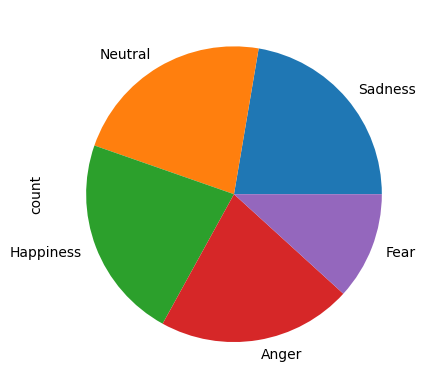

In [19]:
# LOOK AT DISTRIBUTION OF CLASSES
df.emotion.value_counts().plot(kind='pie')

In [20]:
ref=ref.groupby('emotion').head(150)
ref['emotion'].value_counts()

emotion
Sadness      150
Neutral      150
Anger        150
Happiness    150
Fear         110
Name: count, dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  936 non-null    object
 1   path     936 non-null    object
dtypes: object(2)
memory usage: 14.8+ KB


In [22]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.9 MB/s eta 0:00:00:00:01


In [23]:
import resampy
from resampy import resample
import librosa

In [24]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets
df = pd.DataFrame(columns=['Features'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  ,res_type='kaiser_fast'
                                  ,duration=3
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    result = np.array([])

    # mean as the feature. Could do min and max etc as well.
    mfccs = np.mean(librosa.feature.mfcc(y=X,
                                        sr=sample_rate,
                                        n_mfcc=20),
                    axis=0)
    result=np.hstack((result, mfccs)) # stacking horizontally

    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    result=np.hstack((result, log_spectrogram)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(X))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=X).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    df.loc[counter] = [result]
    counter=counter+1


# Check a few records to make sure its processed successfully
print(len(df))
df.head()

710


,Features
0,"[-12.381026268005371, -9.542945861816406, -8.107836723327637, -10.367447853088379, -11.731429100036621, -11.530508995056152, -10.168837547302246, -10.116846084594727, -11.528142929077148, -10.513201713562012, -9.856354713439941, -12.338125228881836, -13.504814147949219, -12.06633186340332, -11.189920425415039, -9.584145545959473, -8.28911304473877, -9.151006698608398, -9.878329277038574, -10.271520614624023, -11.436841011047363, -9.50614070892334, -9.546670913696289, -9.623440742492676, -8.609844207763672, -9.68250846862793, -11.710545539855957, -9.992817878723145, -9.719764709472656, -10.431150436401367, -8.795088768005371, -7.455998420715332, -6.3820481300354, -6.90448522567749, -8.348085403442383, -6.798829078674316, -5.028145790100098, -6.228995323181152, -5.948742866516113, -6.107975006103516, -7.808383941650391, -7.105749607086182, -5.69312047958374, -6.144762992858887, -5.591217994689941, -5.082350730895996, -5.4380998611450195, -4.4306840896606445, -4.762460708618164, -2.5745770931243896, -1.5589277744293213, -1.3156118392944336, -1.5361454486846924, -2.008148670196533, -3.121314764022827, -2.6653037071228027, -3.3222198486328125, -4.178963661193848, -2.927293300628662, -2.683861255645752, -1.9426765441894531, -1.7900447845458984, -2.7508368492126465, -3.434701919555664, -3.538694381713867, -2.5164425373077393, -3.272212266921997, -4.415675163269043, -2.5934700965881348, -2.5636959075927734, -5.339735984802246, -4.694915771484375, -5.729171276092529, -7.195477485656738, -6.06866455078125, -5.942386627197266, -6.620887756347656, -5.916204929351807, -3.8183493614196777, -3.037673234939575, -4.457236289978027, -5.997949123382568, -4.892191410064697, -3.5026745796203613, -3.2917046546936035, -4.244401454925537, -3.356433868408203, -3.162094831466675, -5.787832260131836, -6.069521427154541, -5.503506660461426, -3.7608017921447754, -2.3552660942077637, -2.202390193939209, -4.276184558868408, -2.9656333923339844, -2.5789942741394043, -3.408966064453125, -3.487443447113037, -5.671109199523926, ...]"
1,"[-14.124613761901855, -14.538169860839844, -13.440061569213867, -12.728769302368164, -14.906875610351562, -16.090078353881836, -16.289644241333008, -15.436895370483398, -17.05685043334961, -16.66499137878418, -14.327392578125, -13.571739196777344, -13.046526908874512, -13.334770202636719, -13.519233703613281, -12.933195114135742, -12.677644729614258, -12.866273880004883, -14.47142505645752, -14.948039054870605, -13.566096305847168, -12.465224266052246, -13.516000747680664, -15.641316413879395, -16.190908432006836, -15.66435432434082, -15.097434997558594, -15.05755615234375, -12.98950481414795, -7.850330352783203, -4.457220077514648, -3.4538943767547607, -3.903134822845459, -4.124833106994629, -3.404520034790039, -3.6119048595428467, -5.600663185119629, -7.765334129333496, -8.547605514526367, -9.196639060974121, -10.401209831237793, -10.674324035644531, -11.084146499633789, -11.08430004119873, -12.037163734436035, -11.77372932434082, -9.734233856201172, -9.300545692443848, -9.532071113586426, -5.17043924331665, -2.330622911453247, -0.9522507786750793, -1.639828085899353, -3.497020721435547, -4.56904411315918, -4.19667387008667, -4.389676570892334, -4.890128135681152, -5.587289333343506, -5.530651569366455, -5.514034271240234, -5.822022438049316, -6.394675254821777, -6.101672649383545, -6.419447422027588, -6.985356330871582, -7.798281192779541, -9.679709434509277, -10.864145278930664, -9.533879280090332, -6.80938720703125, -4.021080017089844, -3.600924253463745, -3.969212770462036, -3.5060601234436035, -3.222008466720581, -3.8232758045196533, -4.356793403625488, -4.357456684112549, -3.6893303394317627, -3.499635696411133, -3.5358662605285645, -3.716205596923828, -5.303531646728516, -6.656301021575928, -6.227585792541504, -6.739443302154541, -5.986074924468994, -5.202101230621338, -5.260785102844238, -5.033890724182129, -3.9907889366149902, -3.2164082527160645, -3.16644549369812, -4.842104911804199, -6.004166603088379,

In [25]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['Features'].values.tolist())],axis=1)
df[:5]

,emotion,path,0,1,2,3,4,5,6,7,...,521,522,523,524,525,526,527,528,529,530
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav,-12.381026,-9.542946,-8.107837,-10.367448,-11.731429,-11.530509,-10.168838,-10.116846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav,-14.124614,-14.538170,-13.440062,-12.728769,-14.906876,-16.090078,-16.289644,-15.436895,...,0.662092,0.616642,0.605096,0.606742,0.634006,0.700455,0.764195,0.790132,0.773343,0.049157
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav,-24.013033,-21.973522,-20.949430,-19.631718,-20.120037,-21.490179,-22.039381,-21.051138,...,0.723497,0.653092,0.576960,0.593563,0.628601,0.656681,0.647793,0.673152,0.708287,0.041575
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav,-16.641634,-15.324930,-14.161563,-14.813192,-14.417418,-14.564794,-13.874750,-14.339895,...,0.591730,0.678176,0.655559,0.608755,0.634748,0.739960,0.827966,0.766171,0.678103,0.016744
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav,-22.990042,-22.167454,-21.677198,-20.343527,-19.601223,-20.209036,-20.131161,-17.886219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(739, 533)


,emotion,path,0,1,2,3,4,5,6,7,...,521,522,523,524,525,526,527,528,529,530
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav,-12.381026,-9.542946,-8.107837,-10.367448,-11.731429,-11.530509,-10.168838,-10.116846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav,-14.124614,-14.538170,-13.440062,-12.728769,-14.906876,-16.090078,-16.289644,-15.436895,...,0.662092,0.616642,0.605096,0.606742,0.634006,0.700455,0.764195,0.790132,0.773343,0.049157
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav,-24.013033,-21.973522,-20.949430,-19.631718,-20.120037,-21.490179,-22.039381,-21.051138,...,0.723497,0.653092,0.576960,0.593563,0.628601,0.656681,0.647793,0.673152,0.708287,0.041575
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav,-16.641634,-15.324930,-14.161563,-14.813192,-14.417418,-14.564794,-13.874750,-14.339895,...,0.591730,0.678176,0.655559,0.608755,0.634748,0.739960,0.827966,0.766171,0.678103,0.016744
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav,-22.990042,-22.167454,-21.677198,-20.343527,-19.601223,-20.209036,-20.131161,-17.886219,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','emotion'],axis=1)
                                                    , df.emotion
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,521,522,523,524,525,526,527,528,529,530
335,-14.655348,-14.566893,-14.296782,-13.059370,-13.845644,-12.926895,-9.687238,-7.748655,-6.666164,-5.670410,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
153,-9.101832,-11.400067,-16.995960,-16.098520,-14.915571,-15.657080,-14.806479,-15.486684,-15.524406,-15.719004,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75,-8.222618,-7.946221,-7.476995,-7.369956,-7.316063,-8.070436,-9.183180,-9.452735,-10.407411,-11.775808,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
591,-8.127458,-10.592766,-20.382923,-19.051058,-17.508316,-17.143879,-17.190594,-17.353725,-17.850254,-18.198101,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
277,-19.290859,-19.165285,-19.431385,-20.513460,-20.469975,-19.325785,-20.175106,-21.209471,-19.098680,-17.523586,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
68,-17.788103,-18.375376,-19.647375,-20.364025,-18.254871,-16.119518,-15.965616,-16.540228,-15.696417,-15.349698,...,0.59583,0.577462,0.58749,0.611517,0.606016,0.64992,0.627672,0.672143,0.662431,0.033625
434,-22.474426,-20.317505,-21.446178,-20.531450,-19.437813,-19.305210,-18.337828,-19.273926,-20.648464,-19.325548,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
188,-16.872419,-15.950442,-16.186420,-16.181225,-14.967310,-15.155843,-15.271563,-14.160680,-14.904848,-15.721258,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
271,-15.440886,-15.056524,-14.640190,-13.966952,-13.596670,-12.979601,-14.989352,-18.524063,-18.251394,-16.166580,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
236,-5.814046,-8.440666,-13.404056,-15.227534,-15.534676,-14.959142,-14.804855,-16.483414,-18.151890,-19.445934,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [28]:
df.head()

,emotion,path,0,1,2,3,4,5,6,7,...,521,522,523,524,525,526,527,528,529,530
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav,-12.381026,-9.542946,-8.107837,-10.367448,-11.731429,-11.530509,-10.168838,-10.116846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav,-14.124614,-14.538170,-13.440062,-12.728769,-14.906876,-16.090078,-16.289644,-15.436895,...,0.662092,0.616642,0.605096,0.606742,0.634006,0.700455,0.764195,0.790132,0.773343,0.049157
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav,-24.013033,-21.973522,-20.949430,-19.631718,-20.120037,-21.490179,-22.039381,-21.051138,...,0.723497,0.653092,0.576960,0.593563,0.628601,0.656681,0.647793,0.673152,0.708287,0.041575
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav,-16.641634,-15.324930,-14.161563,-14.813192,-14.417418,-14.564794,-13.874750,-14.339895,...,0.591730,0.678176,0.655559,0.608755,0.634748,0.739960,0.827966,0.766171,0.678103,0.016744
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav,-22.990042,-22.167454,-21.677198,-20.343527,-19.601223,-20.209036,-20.131161,-17.886219,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
print(df['emotion'].apply(type).value_counts())

emotion
<class 'str'>    710
<class 'int'>     29
Name: count, dtype: int64


In [30]:
# df['emotion'] = df['emotion'].astype(str)
# y_train = to_categorical(lb.fit_transform(y_train.astype(str)))
# y_test = to_categorical(lb.fit_transform(y_test.astype(str)))

In [31]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
df['emotion'] = df['emotion'].astype(str)
y_train = df['emotion'].astype(str)
y_test = df['emotion'].astype(str)
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
(591, 531, 1)
(148, 531, 1)


In [32]:
lb.classes_

array(['0', 'Anger', 'Fear', 'Happiness', 'Neutral', 'Sadness'],
      dtype=object)

In [33]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
import pandas as pd
df_mel = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)

    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)

    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)

    df_mel.loc[counter] = [log_spectrogram]
    counter=counter+1

print(len(df_mel))
df_mel.head()

710


,mel_spectrogram
0,"[-35.359257, -34.412033, -35.858456, -38.58452, -39.221817, -39.322952, -39.394444, -38.84309, -39.592117, -39.72254, -39.930267, -40.89714, -40.65486, -39.70127, -39.906864, -40.044846, -39.78883, -39.528202, -39.069508, -39.42649, -39.26819, -39.26472, -39.386223, -38.97824, -38.679665, -38.799187, -38.849503, -38.885445, -38.126896, -34.36724, -32.047535, -31.89372, -28.612434, -27.471369, -27.980625, -27.75979, -27.86214, -28.18887, -27.705072, -26.939995, -27.788912, -29.779903, -31.423277, -31.293528, -30.765696, -29.783562, -26.851692, -22.28991, -21.33677, -20.724592, -19.405724, -19.260984, -18.940533, -19.233883, -19.566227, -20.3277, -21.017853, -23.24389, -22.1376, -19.41019, -19.032116, -18.596552, -17.198557, -16.851048, -17.437841, -19.926878, -22.101084, -23.621002, -24.071243, -24.139814, -24.39857, -24.882912, -26.093239, -27.588617, -28.521969, -27.81696, -24.874659, -23.620293, -23.870161, -23.947037, -23.913887, -25.495384, -27.322067, -29.833775, -31.552168, -32.080914, -31.676834, -30.379562, -30.926489, -32.9294, -33.314476, -29.547222, -26.87334, -27.021296, -26.640387, -26.409723, -26.201202, -26.15904, -26.618067, -27.408476, ...]"
1,"[-41.959034, -39.349365, -38.77722, -38.1578, -38.151966, -38.879578, -39.421436, -39.683437, -41.04263, -41.607872, -41.30272, -40.348057, -40.567158, -40.50971, -39.85374, -39.277905, -39.16769, -39.548286, -39.83202, -39.809418, -39.58783, -39.813187, -39.599945, -39.009235, -39.59873, -39.607967, -39.64608, -38.645798, -34.951054, -24.814156, -18.004328, -16.156456, -16.264833, -16.904982, -18.783186, -22.05663, -26.69859, -32.147053, -33.367992, -33.85623, -34.66356, -34.723366, -35.35488, -37.081127, -36.97613, -37.09599, -31.338234, -23.865292, -23.683065, -18.360884, -12.753241, -13.181488, -15.751022, -18.470291, -20.740135, -23.052313, -22.987309, -21.832348, -21.060812, -20.481133, -20.711658, -21.964731, -24.11388, -25.942894, -27.842302, -29.96331, -31.775614, -35.624912, -30.247316, -21.320507, -16.767525, -10.405515, -8.163669, -6.5616765, -5.3580694, -4.782559, -5.0248747, -5.8714247, -6.203084, -5.8438025, -6.6613274, -9.286796, -12.456618, -14.962838, -16.568874, -18.072084, -19.2879, -18.970478, -16.14642, -13.40228, -11.1233835, -9.688035, -9.6880665, -10.064597, -12.4733925, -14.20362, -12.666126, -11.664649, -11.294555, -11.773185, ...]"
2,"[-51.939022, -50.44595, -49.829266, -49.375763, -49.264988, -49.386402, -49.676495, -49.88462, -50.139053, -50.032516, -49.81637, -50.026524, -50.342297, -50.18892, -50.265324, -50.42133, -49.857887, -50.13117, -49.983406, -50.22539, -50.28457, -49.70333, -49.578087, -49.71256, -49.407204, -49.191677, -49.051643, -48.753056, -49.008167, -48.929897, -48.01494, -47.03945, -47.94968, -48.344162, -48.045124, -47.47795, -46.864586, -47.24083, -47.457237, -47.508377, -48.12522, -49.236015, -49.5474, -49.621006, -49.55979, -41.29057, -37.06615, -40.107655, -42.437042, -40.543015, -39.15769, -40.358925, -43.84202, -45.470936, -41.98182, -43.045788, -46.6655, -47.807953, -48.36498, -48.057507, -48.285255, -48.834328, -49.11986, -49.45306, -49.067024, -47.444366, -45.627552, -45.41638, -43.10469, -42.721333, -43.02538, -39.594982, -37.832638, -35.849346, -32.27311, -27.78756, -24.40352, -21.891926, -20.823406, -18.400784, -16.268484, -16.078987, -15.329746, -14.347022, -14.873009, -15.210556, -15.899513, -16.340897, -16.52907, -16.931297, -16.803995, -16.891172, -16.093925, -15.46754, -15.110564, -16.021982, -18.805094, -21.612915, -22.581781, -23.154701, ...]"
3,"[-41.229263, -40.67679, -41.53287, -42.42974, -43.395287, -44.08668, -44.530037, -45.338078, -44.73998, -44.010094, -40.28454, -29.768171, -25.82391, -24.638853, -21.60602, -20.06039, -21.557125, -22.973135, -23.770588, -24.659487, -25.61785, -25.846828, -26.033022, -25.427372, -24.920193, -25.12942, -24.870722, -23.642082, -24.030584, -26.197058, -29.645426, -33.509514, -36.11955, -37.833942, -39.03312, -39.03383, -40.12247, -40.811222, -41.

In [34]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df_mel['mel_spectrogram'].values.tolist())],axis=1)
df[:5]

,emotion,path,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav,-35.359257,-34.412033,-35.858456,-38.584518,-39.221817,-39.322952,-39.394444,-38.843090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav,-41.959034,-39.349365,-38.777222,-38.157799,-38.151966,-38.879578,-39.421436,-39.683437,...,-38.778931,-38.626270,-39.298100,-39.624031,-40.462849,-40.479900,-41.211948,-41.124561,-40.539314,-41.190315
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav,-51.939022,-50.445950,-49.829266,-49.375763,-49.264988,-49.386402,-49.676495,-49.884621,...,-48.132050,-48.227707,-47.702114,-48.184925,-49.150654,-49.306557,-49.952942,-50.202282,-50.488605,-51.244854
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav,-41.229263,-40.676788,-41.532871,-42.429741,-43.395287,-44.086681,-44.530037,-45.338078,...,-40.359314,-40.283630,-41.728596,-42.913055,-42.299107,-42.270042,-41.553314,-41.188419,-41.743095,-43.796413
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav,-32.760021,-27.055113,-25.443962,-25.193972,-24.467737,-23.833403,-24.310118,-24.774242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','emotion'],axis=1)
                                                    , df.emotion
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
335,-43.296696,-40.733280,-39.702827,-38.545891,-37.688808,-37.341866,-34.893951,-31.751163,-29.359562,-19.571911,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,-33.961544,-34.456375,-35.453053,-31.962515,-27.333530,-26.773037,-28.149914,-28.491590,-29.306360,-29.469833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,-25.108110,-23.535620,-22.984499,-21.629890,-23.122156,-26.765053,-29.812923,-30.851826,-30.967667,-31.130093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,-34.266071,-35.074959,-38.603912,-39.263664,-33.539772,-28.886194,-29.399399,-31.154367,-33.352268,-37.470085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277,-31.239157,-28.621731,-28.242308,-27.665924,-27.339399,-27.507156,-27.442589,-24.235355,-21.981337,-22.918655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,-31.679834,-29.271439,-28.425781,-26.840166,-25.687016,-24.309263,-23.890760,-22.880264,-22.330606,-22.232971,...,-39.990826,-39.944679,-39.763103,-39.966389,-40.543217,-40.70153,-40.851231,-40.8736,-43.472721,-50.160931
434,-50.901936,-49.699753,-49.696499,-49.718521,-49.730965,-49.441032,-49.253090,-49.406925,-49.321323,-49.403900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,-41.420441,-38.318348,-33.537529,-30.606478,-29.539978,-30.571188,-31.176277,-31.356777,-31.193624,-31.799082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,-43.969189,-41.352356,-40.896584,-40.565411,-40.363178,-40.512302,-40.923397,-41.441238,-41.656128,-41.339493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,-19.886354,-20.331766,-21.485176,-21.167261,-20.950945,-21.012289,-21.926390,-23.004402,-23.609827,-24.708933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
(591, 259, 1)
(148, 259, 1)


In [37]:
data_path = pd.concat([df], axis = 0)
# data_path.to_csv(csv_path,index=False)
data_path.head()

,emotion,path,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav,-35.359257,-34.412033,-35.858456,-38.584518,-39.221817,-39.322952,-39.394444,-38.843090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav,-41.959034,-39.349365,-38.777222,-38.157799,-38.151966,-38.879578,-39.421436,-39.683437,...,-38.778931,-38.626270,-39.298100,-39.624031,-40.462849,-40.479900,-41.211948,-41.124561,-40.539314,-41.190315
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav,-51.939022,-50.445950,-49.829266,-49.375763,-49.264988,-49.386402,-49.676495,-49.884621,...,-48.132050,-48.227707,-47.702114,-48.184925,-49.150654,-49.306557,-49.952942,-50.202282,-50.488605,-51.244854
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav,-41.229263,-40.676788,-41.532871,-42.429741,-43.395287,-44.086681,-44.530037,-45.338078,...,-40.359314,-40.283630,-41.728596,-42.913055,-42.299107,-42.270042,-41.553314,-41.188419,-41.743095,-43.796413
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav,-32.760021,-27.055113,-25.443962,-25.193972,-24.467737,-23.833403,-24.310118,-24.774242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [39]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [40]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [41]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [42]:
X, Y = [], []
for path, emotion in zip(df.path, df.emotion):
    try:
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
    except ValueError as e:
        print(f"ValueError encountered for file {path}: {e}")
        pass

TypeError: Invalid file: nan

In [43]:
len(X), len(Y), data_path.path.shape

(2130, 2130, (739,))

In [44]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,labels
0,0.026820,0.415540,0.427295,0.434146,0.370868,0.314784,0.296145,0.282820,0.417232,0.618904,...,0.000002,1.289326e-06,1.015716e-06,8.187092e-07,9.407395e-07,7.046643e-07,7.309018e-07,5.756903e-07,6.451473e-07,Sadness
1,0.048581,0.436505,0.445596,0.451004,0.393608,0.369589,0.316976,0.332856,0.481405,0.706715,...,0.000177,1.764493e-04,1.832534e-04,1.663833e-04,1.687264e-04,1.749347e-04,1.743323e-04,1.819338e-04,1.754191e-04,Sadness
2,0.030011,0.428166,0.381021,0.414300,0.451787,0.381844,0.302369,0.283471,0.258684,0.399783,...,0.000001,5.294816e-07,3.259865e-07,2.825581e-07,2.425819e-07,1.665591e-07,2.087168e-07,9.664022e-08,8.117261e-09,Sadness
3,0.051762,0.634267,0.556302,0.571003,0.625091,0.571003,0.536407,0.568689,0.578430,0.680041,...,0.000491,2.120276e-04,5.973496e-05,5.285581e-05,9.009355e-05,1.083771e-04,9.189273e-05,4.358925e-05,3.702850e-06,Sadness
4,0.243765,0.649263,0.660975,0.731445,0.741531,0.697752,0.658670,0.611872,0.668550,0.753387,...,0.014245,1.439124e-02,1.396615e-02,1.297254e-02,1.410630e-02,1.405495e-02,1.331019e-02,1.355966e-02,1.450224e-02,Sadness


In [45]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
(1704, 155, 1)
(426, 155, 1)


(2130, 5)

In [46]:
lb.classes_

array(['Anger', 'Fear', 'Happiness', 'Neutral', 'Sadness'], dtype=object)

In [47]:
#Accuarte class labels

In [48]:
data_path = pd.concat([df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head(50)

,emotion,path,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,Sadness,/kaggle/input/tamserdb/11_14_sad.wav,-35.359257,-34.412033,-35.858456,-38.584518,-39.221817,-39.322952,-39.394444,-38.843090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sadness,/kaggle/input/tamserdb/04_04_sad.wav,-41.959034,-39.349365,-38.777222,-38.157799,-38.151966,-38.879578,-39.421436,-39.683437,...,-38.778931,-38.626270,-39.298100,-39.624031,-40.462849,-40.479900,-41.211948,-41.124561,-40.539314,-41.190315
2,Neutral,/kaggle/input/tamserdb/01_05_neu.wav,-51.939022,-50.445950,-49.829266,-49.375763,-49.264988,-49.386402,-49.676495,-49.884621,...,-48.132050,-48.227707,-47.702114,-48.184925,-49.150654,-49.306557,-49.952942,-50.202282,-50.488605,-51.244854
3,Sadness,/kaggle/input/tamserdb/16_18_sad.wav,-41.229263,-40.676788,-41.532871,-42.429741,-43.395287,-44.086681,-44.530037,-45.338078,...,-40.359314,-40.283630,-41.728596,-42.913055,-42.299107,-42.270042,-41.553314,-41.188419,-41.743095,-43.796413
4,Fear,/kaggle/input/tamserdb/21_13_fea.wav,-32.760021,-27.055113,-25.443962,-25.193972,-24.467737,-23.833403,-24.310118,-24.774242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Anger,/kaggle/input/tamserdb/01_09_ang.wav,-51.762817,-50.973965,-50.538849,-48.451023,-46.892277,-44.260876,-44.821491,-48.553185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Sadness,/kaggle/input/tamserdb/17_12_sad.wav,-51.321632,-48.808918,-49.405117,-49.959793,-49.359478,-48.858406,-48.366493,-48.317585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Happiness,/kaggle/input/tamserdb/01_05_hap.wav,-51.671490,-50.458290,-50.133858,-50.428402,-50.600029,-50.737652,-50.391705,-50.631336,...,-50.695923,-50.931541,-51.008362,-50.715542,-50.639271,-51.051048,-50.928940,-50.829464,-51.107780,-51.359146
8,Happiness,/kaggle/input/tamserdb/13_15_hap.wav,-28.328289,-23.213572,-21.150312,-20.688885,-23.551235,-30.786699,-33.786026,-35.343220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Anger,/kaggle/input/tamserdb/11_17_ang.wav,-44.508190,-43.017555,-43.438927,-42.877941,-42.434273,-42.344536,-41.953098,-42.760700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [50]:
def noise(data):
    noise_amp = 0.015*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

def pitch2(data, sampling_rate, pitch_factor=0.6):
    return librosa.effects.pitch_shift(y=data,sr=sampling_rate,n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [51]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [52]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch2(new_data, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically

    return result

In [53]:
X, Y = [], []
for path, emotion in zip(df.path, df.emotion):
    try:
        feature = get_features(path)
        for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
    except ValueError as e:
        print(f"ValueError encountered for file {path}: {e}")
        pass

TypeError: Invalid file: nan

In [54]:
len(X), len(Y), data_path.path.shape

(2840, 2840, (739,))

In [55]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,labels
0,0.026820,0.415540,0.427295,0.434146,0.370868,0.314784,0.296145,0.282820,0.417232,0.618904,...,1.930316e-06,1.289326e-06,1.015716e-06,8.187092e-07,9.407395e-07,7.046643e-07,7.309018e-07,5.756903e-07,6.451473e-07,Sadness
1,0.051458,0.431499,0.447179,0.458784,0.402354,0.374064,0.325915,0.332005,0.474503,0.687045,...,2.370121e-04,2.221238e-04,2.273439e-04,2.256986e-04,2.283498e-04,2.263109e-04,2.274843e-04,2.391508e-04,2.274547e-04,Sadness
2,0.030011,0.428166,0.381021,0.414300,0.451787,0.381844,0.302369,0.283471,0.258684,0.399783,...,1.045489e-06,5.294816e-07,3.259865e-07,2.825581e-07,2.425819e-07,1.665591e-07,2.087168e-07,9.664022e-08,8.117261e-09,Sadness
3,0.033072,0.412760,0.381331,0.417484,0.438342,0.343996,0.279266,0.260685,0.279366,0.406527,...,8.168271e-07,5.123297e-07,3.028297e-07,2.658350e-07,1.940762e-07,1.764784e-07,2.054207e-07,8.286875e-08,8.006046e-09,Sadness
4,0.051762,0.634267,0.556302,0.571003,0.625091,0.571003,0.536407,0.568689,0.578430,0.680041,...,4.906973e-04,2.120276e-04,5.973496e-05,5.285581e-05,9.009355e-05,1.083771e-04,9.189273e-05,4.358925e-05,3.702850e-06,Sadness


In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape



[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(2272, 155, 1)
(568, 155, 1)


(2840, 5)

In [57]:
lb.classes_

array(['Anger', 'Fear', 'Happiness', 'Neutral', 'Sadness'], dtype=object)

In [58]:
import random
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('/kaggle/input/german-model/german_models/model1-emo-db.weights.h5')
model2 = load_model('/kaggle/input/german-model/german_models/model2-emo-db.weights.h5')
model3 = load_model('/kaggle/input/german-model/german_models/model3-emo-db.weights.h5')

models = [model1, model2, model3]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = np.argmax(model1.predict(x_test), axis=1)
prediction2 = np.argmax(model2.predict(x_test), axis=1)
prediction3 = np.argmax(model3.predict(x_test), axis=1)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), prediction3)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = pd.concat([df, pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0])], ignore_index=True)

max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])




###########################################################################
### Explore metrics for the ideal weighted ensemble model.

models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2]

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)


# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# #Print confusion matrix
# cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

# fig, ax = plt.subplots(figsize=(12,12))
# sns.set(font_scale=1.6)
# sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

# # CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
# cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
# plt.figure(figsize = (9,7))
# plt.rcParams['figure.dpi'] = 125
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
# ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.6, top - 0.6)
# plt.title('Confusion Matrix', size=20)
# plt.xlabel('Predicted Classes', size=15)
# plt.ylabel('True Classes', size=15)
# plt.savefig('emo-db-model-2.png')
# plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy Score for model1 =  0.125
Accuracy Score for model2 =  0.12323943661971831
Accuracy Score for model3 =  0.1073943661971831
Accuracy Score for average ensemble =  0.11795774647887323
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Weighted average method
Accuracy Score for model1 =  0.125
Accuracy Score for model2 =  0.12323943661971831
Accuracy Score for model3 =  0.1073943661971831
Accuracy Score for average ensemble =  0.11795774647887323
Accuracy Score for weighted average ensemble =  0.11443661971830986
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Max accuracy of  20.422535211267608  obained w

In [59]:
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.3, 0.1, 0.3]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)


# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# #Print confusion matrix
# cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

# fig, ax = plt.subplots(figsize=(12,12))
# sns.set(font_scale=1.6)
# sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

# # CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
# cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
# plt.figure(figsize = (9,7))
# plt.rcParams['figure.dpi'] = 125
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
# ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.6, top - 0.6)
# plt.title('Confusion Matrix', size=20)
# plt.xlabel('Predicted Classes', size=15)
# plt.ylabel('True Classes', size=15)
# plt.savefig('SAVEE-EMSEMBLE.png')
# plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Weighted average method
Accuracy Score for model1 =  0.125
Accuracy Score for model2 =  0.12323943661971831
Accuracy Score for model3 =  0.1073943661971831
Accuracy Score for average ensemble =  0.11795774647887323
Accuracy Score for weighted average ensemble =  0.11619718309859155
